In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

In [3]:
files = ['Гидраторакс.csv', 'Очаг.csv', 'Снижение пневматизации.csv']

In [4]:
def format_and_save_data(files):
    for file in files:
        df = pd.read_csv(file)
        formatted_data = ((index+1, f'Врач{i}', row[i]) for index, row in df.iterrows() for i in range(1, len(row)))
        formatted_df = pd.DataFrame(formatted_data, columns=['ID Файла', 'Врач', 'Аннотация'])
        formatted_df.to_csv(f'отформатированный_{file}', index=False)

In [5]:
def calculate_and_print_kappa_scores(files):
    kappa_scores = []
    for file in files:
        df = pd.read_csv(file)
        grouped = df.groupby('Врач')
        current_kappa_scores = {name: round(sum(map(lambda group2: cohen_kappa_score(group.pivot(index='ID Файла', columns='Врач', values='Аннотация').values[:,0], group2.pivot(index='ID Файла', columns='Врач', values='Аннотация').values[:,0]), [group2 for name2, group2 in grouped if name != name2])) / (len(grouped) - 1), 3) for name, group in grouped}
        sorted_kappa_scores = dict(sorted(current_kappa_scores.items(), key=lambda x: int(x[0].split('Врач')[1])))
        kappa_scores.append(current_kappa_scores)
    return kappa_scores

In [6]:
def generate_final_markup_and_confidence(df):
    X = df.iloc[:, 1:].values
    df['Сумма оценок'] = df.loc[:, df.columns.str.startswith('Врач№')].sum(axis=1)
    df['Наличие патологии'] = df['Сумма оценок'] > 7
    model = LogisticRegression()
    model.fit(X, df['Наличие патологии'])
    y_pred = model.predict(X)
    probas = model.predict_proba(X)[:, 1]
    return pd.DataFrame({'Итоговая разметка': y_pred.astype(int), 'Уверенность': (abs(probas - 0.5) * 200).astype(int)})

In [7]:
def create_quality_plots(files, *kappa_scores):
    for file, scores in zip(files, kappa_scores):
        df = pd.read_csv(file)

        grouped = df.groupby('Врач')
        current_kappa_scores = {name: round(sum(map(lambda group2: cohen_kappa_score(group.pivot(index='ID Файла', columns='Врач', values='Аннотация').values[:,0], group2.pivot(index='ID Файла', columns='Врач', values='Аннотация').values[:,0]), [group2 for name2, group2 in grouped if name != name2])) / (len(grouped) - 1), 3) for name, group in grouped}

        sorted_kappa_scores = dict(sorted(current_kappa_scores.items(), key=lambda x: x[1]))

        doctors = [f"Врач {name.split('Врач')[1]}" for name in sorted(sorted_kappa_scores.keys(), key=lambda x: int(x.split('Врач')[1]))]
        avg_scores = [sorted_kappa_scores[f'Врач{i+1}'] for i in range(len(sorted_kappa_scores))]

        bottom_doctors = sorted(sorted_kappa_scores.items(), key=lambda x: x[1], reverse=True)[-int(len(sorted_kappa_scores) * 0.2):]
        bottom_doctors_names = [doctor[0] for doctor in bottom_doctors]
        plt.figure(figsize=(8, 6))
        bar_colors = ['skyblue' if doctor not in bottom_doctors_names else 'salmon' for doctor in doctors]
        plt.bar(doctors, avg_scores, color=bar_colors)
        plt.xlabel('Врач')
        plt.ylabel('Средний коэффициент Каппа')
        plt.title(f'Качество разметки каждого врача для {file.split(".")[0]}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [8]:
format_and_save_data(files)
kappa_scores = calculate_and_print_kappa_scores([f'отформатированный_{file}' for file in files])
hydrothorax_results = generate_final_markup_and_confidence(pd.read_csv('Гидраторакс.csv'))
focus_results = generate_final_markup_and_confidence(pd.read_csv('Очаг.csv'))
pneumatization_reduction_results = generate_final_markup_and_confidence(pd.read_csv('Снижение пневматизации.csv'))
hydrothorax_results.to_csv('итоговая_разметка_Гидраторакс.csv', index=False)
focus_results.to_csv('итоговая_разметка_Очаг.csv', index=False)
pneumatization_reduction_results.to_csv('итоговая_разметка_Снижение пневматизации.csv', index=False)

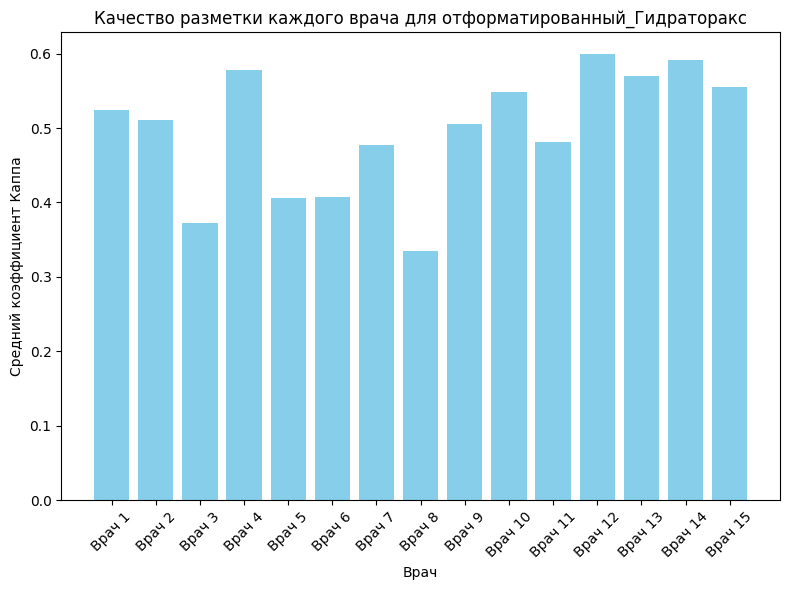

Качество разметки для Гидраторакс
Врач 1: 0.524
Врач 2: 0.511
Врач 3: 0.372
Врач 4: 0.578
Врач 5: 0.406
Врач 6: 0.408
Врач 7: 0.477
Врач 8: 0.335
Врач 9: 0.505
Врач 10: 0.548
Врач 11: 0.481
Врач 12: 0.599
Врач 13: 0.57
Врач 14: 0.591
Врач 15: 0.555
Худшие врачи для патологии 'Гидраторакс':
('Врач5', 0.406)
('Врач3', 0.372)
('Врач8', 0.335)


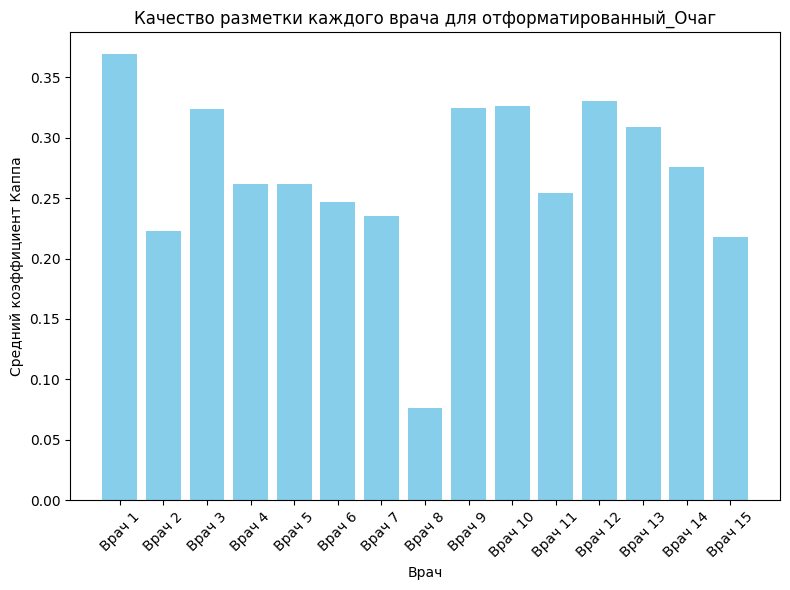

Качество разметки для Очаг
Врач 1: 0.369
Врач 2: 0.223
Врач 3: 0.324
Врач 4: 0.262
Врач 5: 0.262
Врач 6: 0.247
Врач 7: 0.235
Врач 8: 0.076
Врач 9: 0.325
Врач 10: 0.326
Врач 11: 0.254
Врач 12: 0.33
Врач 13: 0.309
Врач 14: 0.276
Врач 15: 0.218
Худшие врачи для патологии 'Очаг':
('Врач2', 0.223)
('Врач15', 0.218)
('Врач8', 0.076)


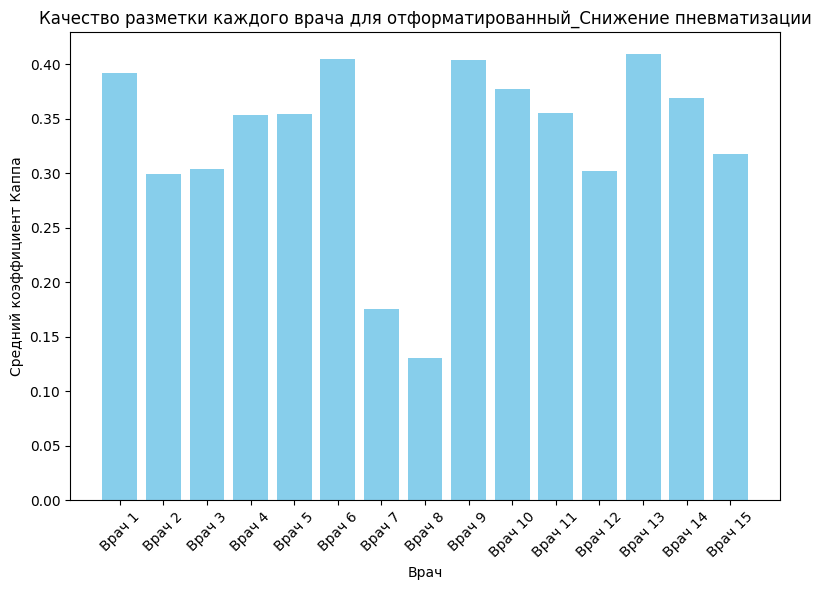

Качество разметки для Снижение пневматизации
Врач 1: 0.392
Врач 2: 0.299
Врач 3: 0.304
Врач 4: 0.353
Врач 5: 0.354
Врач 6: 0.405
Врач 7: 0.175
Врач 8: 0.13
Врач 9: 0.404
Врач 10: 0.377
Врач 11: 0.355
Врач 12: 0.302
Врач 13: 0.409
Врач 14: 0.369
Врач 15: 0.318
Худшие врачи для патологии 'Снижение пневматизации':
('Врач2', 0.299)
('Врач7', 0.175)
('Врач8', 0.13)


In [9]:
for file, scores in zip(files, kappa_scores):
    create_quality_plots([f'отформатированный_{file}'], scores)
    print(f"Качество разметки для {file.split('.')[0]}")
    df = pd.read_csv(f'отформатированный_{file}')
    grouped = df.groupby('Врач')
    sorted_kappa_scores = dict(sorted({name: round(sum(map(lambda group2: cohen_kappa_score(group.pivot(index='ID Файла', columns='Врач', values='Аннотация').values[:,0], group2.pivot(index='ID Файла', columns='Врач', values='Аннотация').values[:,0]), [group2 for name2, group2 in grouped if name != name2])) / (len(grouped) - 1), 3) for name, group in grouped}.items(), key=lambda x: int(x[0].split('Врач')[1])))
    for name, score in sorted_kappa_scores.items():
        print(f"Врач {name.split('Врач')[1]}: {score}")
    print(f"Худшие врачи для патологии '{file.split('.')[0]}':")
    bottom_doctors = sorted(sorted_kappa_scores.items(), key=lambda x: x[1], reverse=True)[-int(len(sorted_kappa_scores) * 0.2):]
    for doctor in bottom_doctors:
        print(doctor)

In [10]:
print("Оценка качества итоговой разметки")
for file, results in zip(['Гидраторакс.csv', 'Очаг.csv', 'Снижение пневматизации.csv'], [hydrothorax_results, focus_results, pneumatization_reduction_results]):
    print(f"{file.split('.')[0]}")
    df = pd.read_csv(file)
    kappa_scores = []
    for col in df.columns[1:]:
        kappa = cohen_kappa_score(df[col], results['Итоговая разметка'])
        kappa_scores.append(kappa)
    avg_kappa = sum(kappa_scores) / len(kappa_scores)
    print(f"качество итоговой оценки: {avg_kappa:.3f}")

Оценка качества итоговой разметки
Гидраторакс
качество итоговой оценки: 0.661
Очаг
качество итоговой оценки: 0.418
Снижение пневматизации
качество итоговой оценки: 0.509
